In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam


from absl import app

# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
from scipy.stats import norm, kstest
from scipy.spatial.distance import jensenshannon as jsd

import seaborn as sns

Using TensorFlow backend.


## Load models

In [2]:
models = "/home/aogorodnikov/aae_2Dlatent"
wd = "/home/aogorodnikov/test"
batch = 16

In [3]:
def model_compile(models):
    '''
    Loads and compiles models
    :param models: directory with encoder, decoder and discriminator

    :return: compiled autoencoder and discriminator
    '''

    encoder = load_model(os.path.join(models, "encoder.h5"))
    decoder = load_model(os.path.join(models, "decoder.h5"))

    # get input and latent space shapes
    latent_dim = encoder.get_layer(index=-1).output_shape[1]
    input_dim = encoder.get_layer(index=0).input_shape[1:]

    # compile imported models into assembled autoencoder
    autoencoder_input = Input(shape=input_dim)
    autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
    autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])

    return autoencoder, encoder, input_dim, latent_dim

In [4]:
autoencoder, encoder, input_dim, latent_dim = model_compile(models)

Instructions for updating:
Colocations handled automatically by placer.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def mse_batch(data_x, data_y, input_dim):
    # TODO: docstring
    shape_1 = input_dim[0]
    shape_2 = input_dim[1:]
    reshape_x = np.reshape(data_x, (shape_1, np.prod(shape_2)))
    reshape_y = np.reshape(data_y, (shape_1, np.prod(shape_2)))
    return mse(reshape_x, reshape_y)

In [6]:
def jsd_batch(latent_x, latent_dim):
    '''
    Function to compute adversarial loss
    :param latent_x: encoded latent space
    :return: KL divergence b/w prior
    '''
    prior = np.random.randn(latent_dim) * 5.
    return jsd(norm.pdf(latent_x), norm.pdf(prior))

In [7]:
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False)
# load data
data_in = data_loader.flow_from_directory(
    wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    shuffle=False,
    class_mode='input')

Found 560 images belonging to 1 classes.


In [ ]:
batch_index = 0

data = data_in.next()
data_list = data[0]
data_size = len(data_list)

ae_pred = autoencoder.predict_on_batch(data_list)
fake_latent = encoder.predict(data_list)

In [10]:
lol = [mse_batch(data_list[x], ae_pred[x], input_dim) for x in range(len(ae_pred))]

In [11]:
def kld_batch(latent_x, latent_dim):
    '''
    Function to compute adversarial loss
    :param latent_x: encoded latent space
    :return: KL divergence b/w prior
    '''
    prior = np.random.randn(latent_dim) * 5.
    return entropy(norm.pdf(latent_x), norm.pdf(prior))

In [12]:
shit  = [kld_batch(x, latent_dim) for x in fake_latent]
shit_jsd  = [jsd_batch(x, latent_dim) for x in fake_latent]

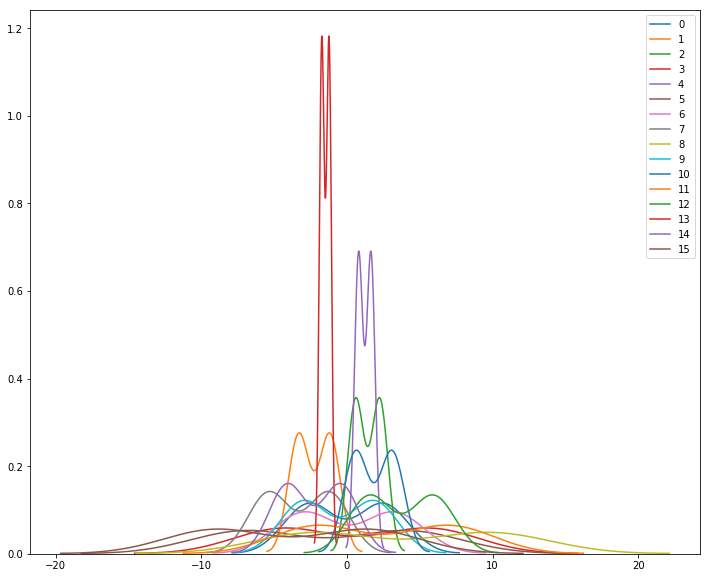

In [13]:
df = list(zip(data_in.filepaths[:17],fake_latent))
fig, ax = plt.subplots(figsize=(12, 10))
for l in range(len(df)):
    to_plot = df[l][1]
    g = sns.distplot(to_plot, hist=False, label=l)
   

In [14]:
list(zip(data_in.filepaths[:17],lol, shit, shit_jsd))

[('/home/aogorodnikov/test/polarity/Pt04_r01c01_f02_0032.tif',
  0.004286723,
  9.846563145077408,
  0.4312114436253821),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f08_0257.tif',
  0.004990554,
  0.19907419256729098,
  0.001028179018949496),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f09_0342.tif',
  0.0056135403,
  4.004859811769163,
  0.013021514042271067),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f10_0234.tif',
  0.0022708082,
  56.38486942960255,
  0.1609394503626662),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f10_0236.tif',
  0.0077688326,
  0.01957597465216042,
  0.10049812679268588),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f11_0224.tif',
  0.010130838,
  8.167170935439303,
  0.00017219313090207505),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f13_0716.tif',
  0.0060097785,
  0.01930255430074132,
  0.585911078769804),
 ('/home/aogorodnikov/test/polarity/Pt04_r01c01_f14_0961.tif',
  0.003951793,
  20.419737527550332,
  0.8259089705271982),
 ('/h

In [30]:
np.mean(lol)

0.0038870783

In [7]:
data = data_in.next()
data_list = data[0]
data_size = len(data_list)

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [11]:
autoencoder.evaluate_generator(data_in)[0]

0.005301421973854303